<a href="https://colab.research.google.com/github/EunjinAn/data-science_aalborg/blob/main/Eunjin_of_M2_W1_Elites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic packaging for network exploration
import pandas as pd
import networkx as nx
from community import community_louvain

import altair as alt

# Exploring the graph of Danish Power Elites

![](https://source.unsplash.com/GWe0dlVD9e0)

> Many people dream of being one of them, but only few make it all the way to the top. According to two CBS researchers, it takes more than just hard work to get to the top of the Danish hierarchy of power. [read more](https://www.cbs.dk/en/alumni/news/a-look-the-danish-power-elite)

In this project we are going to construct and explore a network of Danish power elites derived from boards of various organisations in th country.
We will construct an association network: Who is being in the same board? And first explore "basic" centrality indicators. Then identify communities and central persons within those. Finally we look at some "fancier" interactive network visualisation.

In this tutorial we will be using some more advanced Pandas techniques that may be new for you. Use the documentation if in doubt.

You can read some related research [here](https://research-api.cbs.dk/ws/portalfiles/portal/57663543/anton_grau_larsen_and_christoph_houmann_ellersgaard_who_listens_to_the_top_acceptedversion.pdf)



# Obtaining exploring data

## Loading the data

In [ ]:
# Import data :-) and quick check
data = pd.read_csv('https://github.com/SDS-AAU/SDS-master/raw/master/00_data/networks/elite_den17.csv')
data.head()

NAME                                        AFFILIATION  \
0      Aage Almtoft                              Middelfart Sparekasse   
1  Aage B. Andersen  Foreningen Østifterne - Repræsentantskab (Medl...   
2  Aage Christensen                                  ÅRHUS SØMANDSHJEM   
3          Aage Dam  Brancheforeningen automatik, tryk & transmissi...   
4          Aage Dam                         Dansk Erhverv (bestyrelse)   

       ROLE                                              TAGS  POSITION_ID  \
0    Member                 Corporation, FINA, Banks, Finance            1   
1    Member    Charity, Foundation, Insurance, Socialomraadet            4   
2  Chairman                       Foundation, Marine, Tourism            6   
3  Chairman  Business association, Interest group, Technology            8   
4    Member                             Employers association            9   

       ID        SECTOR          TYPE  \
0   95023  Corporations           NaN   
1   67511           NGO  Organisation   
2  100903   Foundations           NaN   
3   69156           NGO  Organisation   
4   72204           NGO          Stat   

                                         DESCRIPTION               CREATED  \
0  Automatisk CVR import at 2016-03-12 18:01:28: ...  2016-03-12T18:01:28Z   
1                                           Direktør  2016-02-05T14:45:10Z   
2  Automatisk CVR import at 2016-03-12 18:08:31: ...  2016-03-12T18:08:31Z   
3    Formand, Adm. direktør, Bürkert Contromatic A/S  2016-02-10T15:18:47Z   
4        Adm. dir. Aage Dam- Bürkert-Contromatic A/S  2016-02-16T10:49:01Z   

   ARCHIVED          LAST_CHECKED    CVR_PERSON  CVR_AFFILIATION  PERSON_ID  \
0       NaN  2017-11-09T15:38:01Z  4.003984e+09       24744817.0          1   
1       NaN  2016-02-12T14:41:09Z           NaN              NaN          3   
2       NaN  2017-11-09T15:50:09Z  4.000054e+09       29094411.0          4   
3       NaN  2016-02-10T14:19:20Z           NaN              NaN          5   
4       NaN  2016-02-16T11:55:34Z           NaN       43232010.0          5   

   AFFILIATION_ID  
0            3687  
1            2528  
2             237  
3             469  
4            1041

As we can see each person has different attributes, among others IDs and affiliation IDs. There are also data for sector and role tha we could use for filtering or EDA.

In [ ]:
data['AFFILIATION'].value_counts(ascending=False).nlargest(20)

H.M. Dronningens 75-års fødselsdag                                                           803
Axcelfuture - konferencedeltagere                                                            332
Gallatafler ved statsbesøg (2016-17) I                                                       250
Uddannelses- og Forskningsministeriet (Kvalifikationsnævnet - Medlemmer)                     232
Miljø- og Fødevareministeriet (Natur- og Miljøklagenævnet - Den sagkyndige sammensætning)    214
Folketingets Presseloge (Institutioner under Folketinget) (Medlemmer)                        199
Reception på Kongeskibet Dannebrog (2017)                                                    196
Gallatafler ved statsbesøg (2016-17) II                                                      195
Landvind i en ny virkelighed (Konference)                                                    148
Nytårskur og -taffel (2016 – 2018)                                                           146
Venstre (Hovedbestyrelse)     

In [ ]:
data['SECTOR'].value_counts(ascending=False)

NGO             17720
State           13601
Corporations     7989
Foundations      6987
VL_networks      3803
Events           1948
Parliament       1087
Commissions       795
Municipal         320
Family            207
Politics           37
Organisation        6
Name: SECTOR, dtype: int64

In [ ]:
# this would be the way for you to subset for corporate affiliation (which also have CVR numbers)
data = data.query('SECTOR == "Corporations"')
data = data.dropna(subset = ['CVR_AFFILIATION'])

In [ ]:
data['AFFILIATION'].value_counts(ascending=False).nlargest(20)

Kromann Reumert                     55
Bech-Bruun                          54
Gorrissen Federspiel                40
Plesner                             40
EnergiMidt                          31
Lett Law Firm                       27
Syd Energi (SE)                     24
TDC (note)                          24
Bruun & Hjejle                      23
Dansk Retursystem                   22
Alm. Brand                          22
Danske Bank                         21
SEAS-NVE                            20
Rønne & Lundgren                    20
Nykredit Realkredit (Bestyrelse)    20
Carlsberg                           19
Naturgas Fyn                        19
PensionDanmark                      19
Vandcenter Syd                      19
Novo Nordisk                        18
Name: AFFILIATION, dtype: int64

In [ ]:
data['NAME'].value_counts(ascending=False).nlargest(20)

Karen Frøsig                  7
Gert Rinaldo Jonassen         7
Jeppe Christiansen            6
Michael Christiansen 25501    6
Henning Kruse Petersen        6
Jørgen Huno Rasmussen         5
Anders Christen Obel          5
Niels Thomas Heering          5
Preben Sunke                  5
Jens Bjerg Sørensen           5
Lars Nørby Johansen           5
Jørn Ankær Thomsen            5
Niels Jørgen Kornerup         5
John Christiansen 16895       5
Kim Simonsen                  5
Lasse Nyby                    5
Niels Jacobsen 27459          5
David Hellemann               5
Hans Henrik Kjølby 10930      5
John Bull Fisker              5
Name: NAME, dtype: int64

## EDA

In [ ]:
toplot = data['AFFILIATION'].value_counts(ascending=False).nlargest(20).reset_index()
alt.Chart(toplot).mark_bar().encode(
    x='index:N',
    y='AFFILIATION:Q'
)

alt.Chart(...)

## Edgelist construction

Given that each person and affiliation have unique IDs, we have perfect input for network construction




In [ ]:
# select name and IDs
data_select = data[['NAME', 'PERSON_ID', 'AFFILIATION_ID']]

We can create an edge dataframe utilising a "trick" where we merge the dataframe with itself using `AFFILIATION_ID` as key. The only thing that we then need to remove are self-links since a person can not really be in a board with itself.

The initial dataframe has ~60 rows. The new after the merger ~160k. That looks promising.

In [ ]:
# create edge DF by merge with itself.
edges = pd.merge(data_select, data_select, on='AFFILIATION_ID')
edges.head()

NAME_x  PERSON_ID_x  AFFILIATION_ID                  NAME_y  \
0  Aage Almtoft            1            3687            Aage Almtoft   
1  Aage Almtoft            1            3687              Allan Buch   
2  Aage Almtoft            1            3687     Bo Skovby Rosendahl   
3  Aage Almtoft            1            3687           Bo Smith 4493   
4  Aage Almtoft            1            3687  Martin Nørholm Baltser   

   PERSON_ID_y  
0            1  
1          311  
2         4491  
3         4493  
4        24816

In [ ]:
# Filter out self-edges
edges = edges[edges.PERSON_ID_x != edges.PERSON_ID_y]

We are now in a situation whre people that sit in multiple boards together will have one row per board. This can be aggregated in the following way by grouping.



In [ ]:
# grouping to aggregate multiple co-occurences and to generate a weight: 
# How many times did PesonX and PersonY sit in boards together
# reset_index makes everytging from a multi-index-series into a dataframe
edges = edges.groupby(['PERSON_ID_x', 'PERSON_ID_y']).size().reset_index()

In [ ]:
# column "0" is now our weight
edges.head()

PERSON_ID_x  PERSON_ID_y  0
0            1          311  1
1            1         4491  1
2            1         4493  1
3            1        24816  1
4            1        31093  1

In [ ]:
edges[0].value_counts()

1    58824
2     1560
4      222
3       34
5       12
Name: 0, dtype: int64

In [ ]:
# finally we rename the "0" column to weight
edges.rename({0:'weight'}, axis = 1, inplace=True)

In [ ]:
len(edges)

60652

Most of the people co-occure only once. There are only 4 cases where 2 people meet each other in 15 boards. This is also the strongest weight.

## Creating the Graph object with NetworkX

Now we can create a network object from this edgelist. From here we will calculate various centrality measures and perform community detection. Think about the latter as UML (which it actually is).
This will allow us to investigate e.g.:

- Are there power clusters within different domains (education, agriculture...)?
- Who are the top people in these communities



In [ ]:
# Create network object from pandas edgelist
G = nx.from_pandas_edgelist(edges, source='PERSON_ID_x', target='PERSON_ID_y', edge_attr='weight', create_using=nx.Graph())

Using a pandas edgelist as source is a source for the graph object allows us to instantiate it with the weight attribute included

In [ ]:
# We can create a node-attribute dictionary directly from the dataframe (using pandas to_dict)
node_attributes = data_select[['PERSON_ID','NAME']].set_index('PERSON_ID').drop_duplicates().to_dict('index')

In [ ]:
# We now can include the degree as node-attribute
nx.set_node_attributes(G, {G.degree(): 'degree'})

In [ ]:
# and use the node_attribute object to include all that in the graph object
nx.set_node_attributes(G, node_attributes)

In [ ]:
len(G.nodes())

6479

In [ ]:
len(G.edges())

30326

Subsetting og Graph objects in NetworkX is a bit of a challenge sometimes - Well, you need to remember that NetworkX wants us to pass a list of Node-IDs for subsetting. The easiest here (probably also most elegant) is to use a list comprehension with a condition statemen `if d > 1`

In [ ]:
# Subset the graph keeping only nodes with degree > 1
G = nx.subgraph(G, [n for n,d in G.degree() if d > 1])

In [ ]:
# Here we can calculate different centrality indicators as well as partition (community detection)
centrality_dgr = nx.degree_centrality(G)
centrality_eig = nx.eigenvector_centrality_numpy(G, weight = 'weight')

In [ ]:
partition = community_louvain.best_partition(G) #that will take some time...

In [ ]:
# All these indicators can now be set as attribute of the Graph
nx.set_node_attributes(G, centrality_dgr, 'dgr')
nx.set_node_attributes(G, centrality_eig, 'eig')
nx.set_node_attributes(G, partition, 'partition')

## Bringing it back to pandas

Once all graph indicators are in place, we can bring them back to Pandas for easier further analysis 🧐. You can compare that step to inspecting individual clusters identified with e.g. K-means.


In [ ]:
# This is how you turn a Graph object (NetworkX) to a Dataframe
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [ ]:
nodes_df.head()

NAME       dgr           eig  partition
1                Aage Almtoft  0.001389  3.686601e-19          0
311                Allan Buch  0.001389  6.863519e-19          0
4491      Bo Skovby Rosendahl  0.001389  8.278247e-19          0
4493            Bo Smith 4493  0.001389  4.485428e-19          0
24816  Martin Nørholm Baltser  0.001389  7.800745e-19          0

Let's see who are the most central people in DK.
I guess, you'll not be surprised by the result

In [ ]:
# For that we can e.g. sort the dataframe by eigenvector (only first 10 rows)
nodes_df.sort_values('eig', ascending=False)[:10]

NAME  \
20964                               Kronprins Frederik   
7241   Dronning Margrethe Alexandrine Þórhildur Ingrid   
20961                               Kronprinsesse Mary   
31746                                    Prins Joachim   
31743                                  Prinsesse Marie   
19698                             Kim Kristensen 19698   
22130                                    Lasse Harkjær   
33633                             Søren Weiskopf Kruse   
5961                                 Christian Schønau   
25537                               Michael Ehrenreich   

                                                     dgr       eig  partition  
20964  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.112126          9  
7241   ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.111722          9  
20961  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.111322          9  
31746  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.111035          9  
31743  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.110584          9  
19698  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.108724          9  
22130  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.108701          9  
33633  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.108698          9  
5961   ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.105302          9  
25537  ((1, 9), (311, 182), (4491, 39), (4493, 9), (2...  0.105300          9

Let's see if we can find out about the largest communities and the most central people within these:

In [ ]:
# How many communities are there (identified automatically)
nodes_df.partition.nunique()

949

In [ ]:
# Let's look at how many people there are in the top 20
nodes_df.partition.value_counts()[:20]

13    3598
15    3020
2     1588
5     1270
21    1083
10     952
48     902
35     862
33     837
18     803
37     758
6      754
19     740
46     738
76     720
49     648
52     628
53     617
23     611
14     605
Name: partition, dtype: int64

In [ ]:
# Perhaps let's check out the first 10
top10_com = nodes_df.partition.value_counts()[:10].index

In [ ]:
# Complicated approach using NetworkX
# Who are the people in these?
top10_com_nodes = nodes_df[nodes_df.partition.isin(top10_com)].index

# Let's make a subgraph with only these people (one could also do it in pandas)
g_sub = nx.subgraph(G, top10_com_nodes)

# From here to dataframe

In [ ]:
# Simple approach using Pandas
# Now we will limit the resulting dataframe to the top10 communities
nodes_df_top10 = nodes_df[nodes_df.partition.isin(top10_com)]

In [ ]:
nodes_df_top10

NAME       dgr           eig  partition  degree_basic
3           Aage B. Andersen  0.000804  3.005185e-06          2            31
595          Anders Frandsen  0.000804  3.005185e-06          2            31
850      Anders Sørensen 850  0.000804  3.005185e-06          2            31
1579        Anne-Lise Becker  0.000804  3.005185e-06          2            31
1765    Anne-Mette Hvidtsted  0.001142  1.157022e-05          2            44
...                      ...       ...           ...        ...           ...
192638    Erna Jensen 192638  0.000208  2.189736e-08          2             8
192639         Lotte Falsing  0.000208  2.189736e-08          2             8
192640            Mike Axdal  0.000208  2.189736e-08          2             8
192641        Karin Sneevang  0.000208  2.189736e-08          2             8
192642             Uffe Kjær  0.000208  2.189736e-08          2             8

[14915 rows x 5 columns]

In [ ]:
# Let's look at the "most important" people by grouping up and keeping the 5 observations
# with the highest eigenvector centrality
top_people = nodes_df_top10.groupby('partition')['eig'].nlargest(5).reset_index()

In [ ]:
top_people

partition  level_1       eig
0           2    25236  0.011741
1           2    10892  0.008746
2           2    19215  0.002694
3           2     6064  0.002540
4           2    55151  0.002540
5           5    37047  0.015213
6           5    37514  0.008702
7           5     5734  0.002683
8           5    12962  0.002239
9           5    13913  0.002176
10         10     7241  0.070084
11         10    20964  0.069806
12         10    31746  0.069605
13         10    20961  0.069561
14         10    31743  0.069493
15         13    20209  0.020714
16         13    28947  0.017549
17         13    27998  0.016789
18         13    27770  0.015773
19         13    10063  0.015261
20         15     6395  0.004725
21         15     2941  0.004659
22         15    11732  0.004089
23         15    34274  0.003311
24         15    19797  0.003196
25         18    33186  0.001096
26         18     5509  0.000736
27         18    10089  0.000600
28         18    16719  0.000567
29         18    27725  0.000529
30         21    20824  0.002260
31         21     1231  0.001892
32         21    11692  0.001522
33         21    26070  0.001115
34         21    38236  0.001031
35         33     4662  0.002235
36         33     4882  0.001308
37         33    33690  0.001212
38         33    13835  0.001160
39         33     5966  0.000941
40         35    16807  0.008494
41         35    27263  0.000866
42         35    18587  0.000657
43         35    27674  0.000588
44         35    10677  0.000464
45         48    32093  0.002037
46         48    35735  0.001063
47         48    27857  0.000801
48         48    52516  0.000714
49         48    23687  0.000640

In [ ]:
# After that we need to bring back ID's (rename) and Names (merge)
top_people.rename({'level_1':'PERSON_ID'}, axis=1, inplace=True)
top_people = pd.merge(top_people, data_select[['NAME','PERSON_ID']].drop_duplicates(), on='PERSON_ID', how='inner')

In [ ]:
top_people

partition  ...                                             NAME
0           2  ...                       Mette Kynne Frandsen 25236
1           2  ...                        Hans Henning von Rottbøll
2           2  ...            Katia Knipschildt Østergaard Pedersen
3           2  ...                              Christina Hou Holck
4           2  ...                         Ulrik Theophil Jørgensen
5           5  ...                                       Ulla Tofte
6           5  ...                              Vincents Georg Iuul
7           5  ...                      Christian Faurschou la Cour
8           5  ...                              Henrik Wigh-Poulsen
9           5  ...                               Jacob Jensen 13913
10         10  ...  Dronning Margrethe Alexandrine Þórhildur Ingrid
11         10  ...                               Kronprins Frederik
12         10  ...                                    Prins Joachim
13         10  ...                               Kronprinsesse Mary
14         10  ...                                  Prinsesse Marie
15         13  ...                           Kjeld Kirk Kristiansen
16         13  ...                             Ove Ullerup-Petersen
17         13  ...                         Nils Smedegaard Andersen
18         13  ...                                 Niels Smedegaard
19         13  ...                                 Göran Ando 10063
20         15  ...                                Claus Jensen 6395
21         15  ...                                 Bente Sorgenfrey
22         15  ...                           Helle Lizette Risgaard
23         15  ...                                Stina Vrang Elias
24         15  ...                                     Kim Simonsen
25         18  ...                              Søren Hartmann Hede
26         18  ...                                 Charlotte Münter
27         18  ...                          Gorm Toftegaard Nielsen
28         18  ...                            Johan Martini Reimann
29         18  ...                                      Niels Ploug
30         21  ...                         Kristian Korfits Nielsen
31         21  ...                                      Anja Philip
32         21  ...                               Helle Hjorth Bentz
33         21  ...                                   Mikael Sjöberg
34         21  ...                             Ole Egberg Mikkelsen
35         33  ...                            Britta Schall Holberg
36         33  ...                                       Carl Holst
37         33  ...                                     Steen Bitsch
38         33  ...                                Jacob Bjerregaard
39         33  ...                           Christian Schultz 5966
40         35  ...                 Johan Nicolaj Flach de Neergaard
41         35  ...                              Niels Duedahl 27263
42         35  ...                                     Karen Frøsig
43         35  ...                                    Niels Opstrup
44         35  ...                           Hanni Toosbuy Kasprzak
45         48  ...                              Richard Rudolf Sand
46         48  ...                                   Tina Reissmann
47         48  ...                          Niels Walther-Rasmussen
48         48  ...                           Johan Kristian Legarth
49         48  ...                              Mads Bryde Andersen

[50 rows x 4 columns]

Now you can explore the names 😊 Happy stalking! 😏

## Fancier visualisatinos

Let's install some fancy visualisation infrastructure

In [ ]:
!pip install -qq holoviews
!pip install -qq -U bokeh
!pip install -qq datashader

     |████████████████████████████████| 18.5 MB 340 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.3 which is incompatible.
     |████████████████████████████████| 18.2 MB 930 kB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
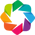

In [ ]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))

In [ ]:
# keeping only top nodes (extreme subsetting)
top_central_nodes = nodes_df[nodes_df.eig > nodes_df.eig.quantile(0.99)].index

In [ ]:
# Create subset graph
g_sub = nx.subgraph(G, top_central_nodes)

In [ ]:
# Create and save a layout.
g_layout = nx.layout.spring_layout(g_sub) 
g_plot = hv.Graph.from_networkx(g_sub, g_layout).opts(tools=['hover'], node_color='partition')
labels = hv.Labels(g_plot.nodes, ['x', 'y'], 'NAME')

In [ ]:
# make the plot
from holoviews.operation.datashader import datashade, bundle_graph
bundled = bundle_graph(g_plot)

In [ ]:
# show the plot
show(hv.render(bundled * labels.opts(text_font_size='6pt', text_color='white', bgcolor='gray')))